## MVP - Engenharia de Sistemas de Software Inteligentes

In [ ]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

## Carga do Dataset

In [11]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/rafgartzia/mvp-eng-sist-inteligentes/main/api/MachineLearning/data/maternal-health-risk.csv"

# Importa o arquivo
dataset = pd.read_csv(url, delimiter=',')

# Realiza a conversão de dados
# Coluna de resultados: converte os valores string em inteiros
dataset.replace({'low risk': 0, 'mid risk': 1, 'high risk': 2}, inplace=True)

# Converte a coluna de temperatura corporal de Fahrenheit para Celsius (1 casa decimal - medida comum de temperatura)
dataset['BodyTemp'] = round((dataset['BodyTemp'] - 32) * 5/9,1)

# Converte coluna de glicemia de mmol/L para mg/dL (1 casa decimal)
dataset['BS'] = round(dataset['BS'] * 18.0182, 1)   


# Mostra as primeiras linhas do dataset
dataset.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,270.3,36.7,86,2
1,35,140,90,234.2,36.7,70,2
2,29,90,70,144.1,37.8,80,2
3,30,140,85,126.1,36.7,70,2
4,35,120,60,109.9,36.7,76,0


## Separação em conjunto de treino e conjunto de teste com holdout

In [12]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,0:6]
y = array[:,6]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

KNN: 0.728787 (0.044092)
CART: 0.806474 (0.035365)
NB: 0.596808 (0.063093)
SVM: 0.616591 (0.031420)


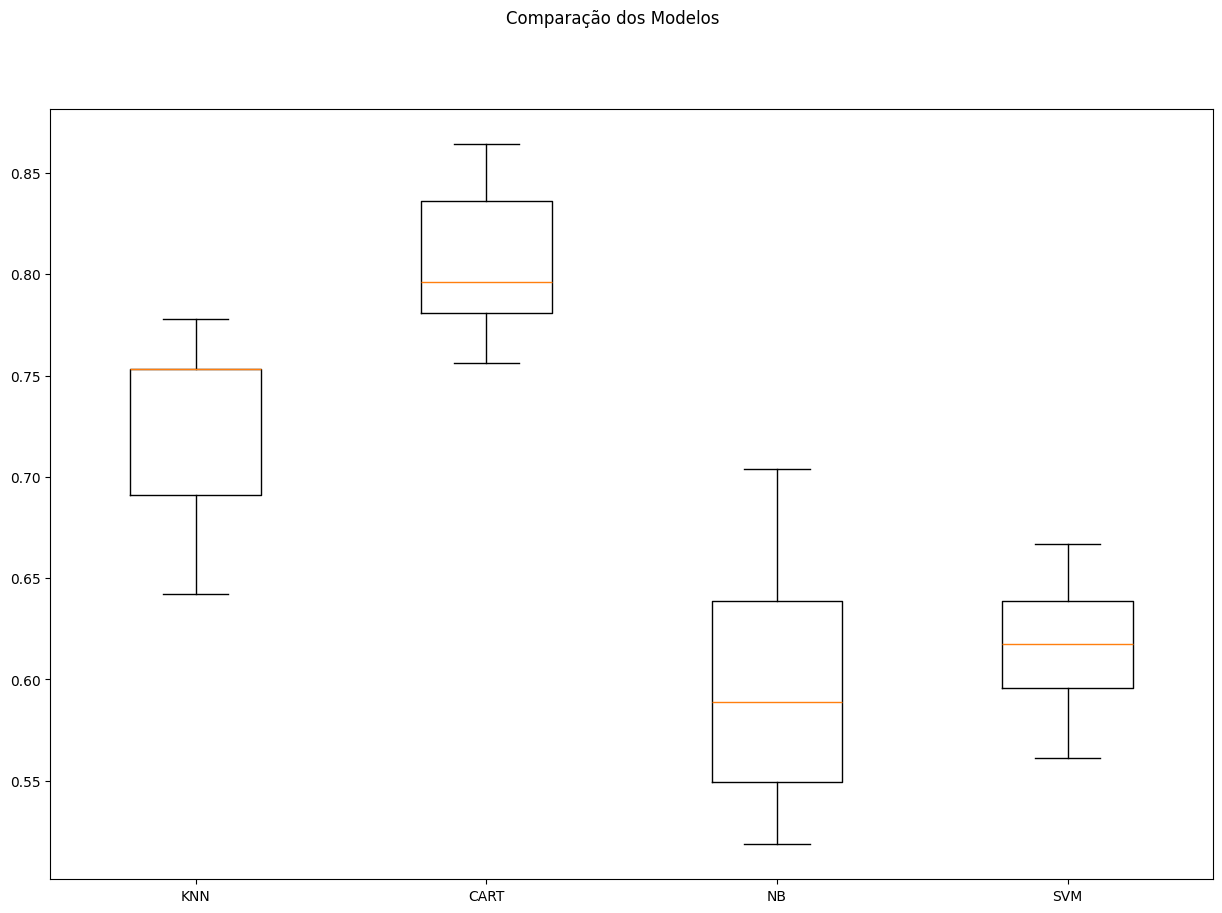

In [13]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.729 (0.044)
CART-orig: 0.806 (0.035)
NB-orig: 0.597 (0.063)
SVM-orig: 0.617 (0.031)
KNN-padr: 0.679 (0.049)
CART-padr: 0.806 (0.038)
NB-padr: 0.597 (0.063)
SVM-padr: 0.698 (0.049)
KNN-norm: 0.671 (0.042)
CART-norm: 0.811 (0.037)
NB-norm: 0.597 (0.063)
SVM-norm: 0.688 (0.046)


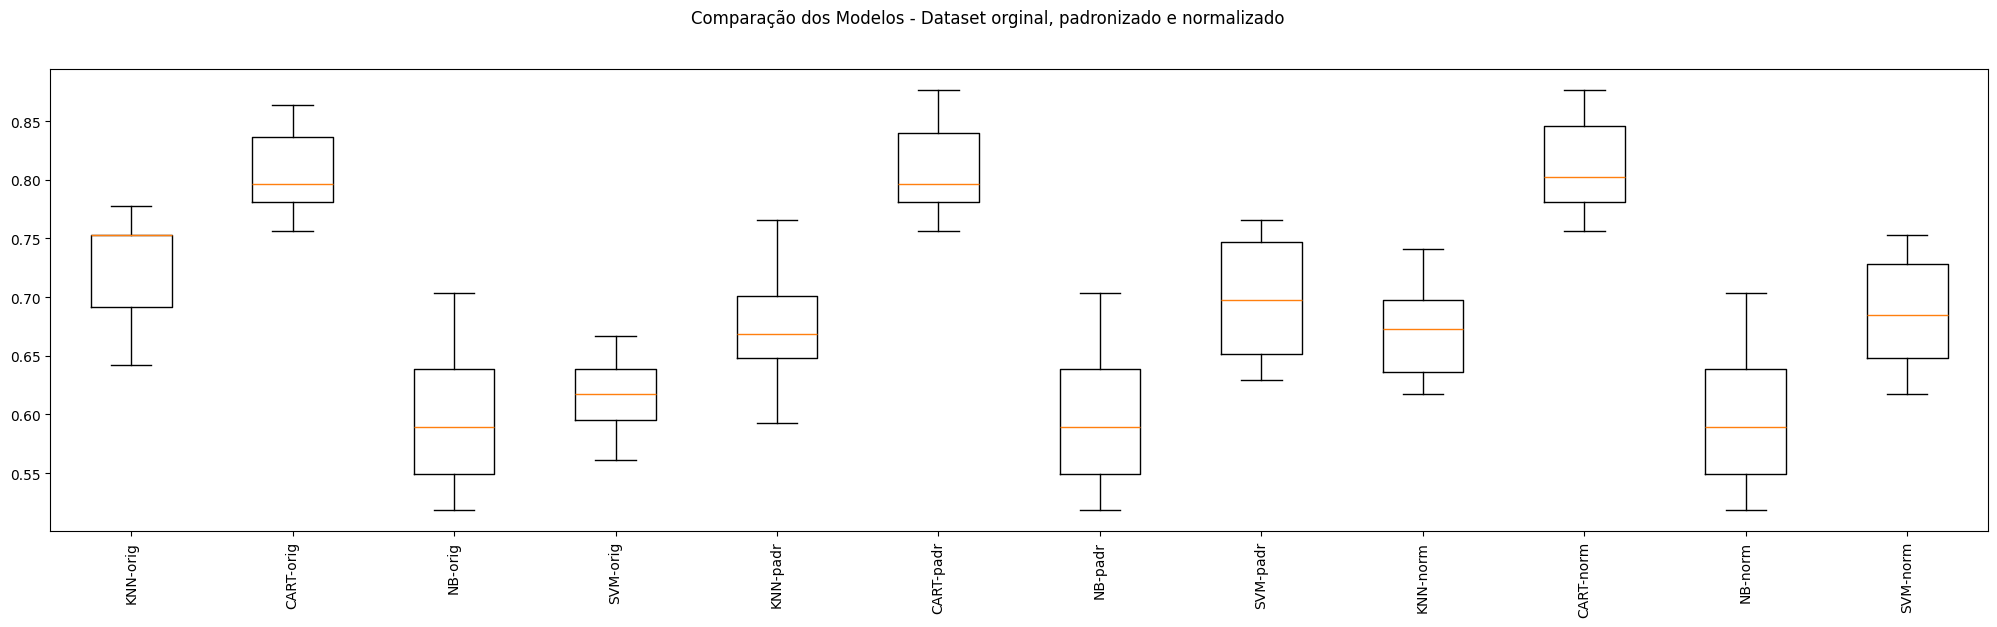

In [14]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização dos hiperparâmetros

In [ ]:
# Tuning do CART

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
cart = ('CART', DecisionTreeClassifier())
#knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())



pipelines.append(('cart-orig', Pipeline(steps=[cart])))
pipelines.append(('cart-padr', Pipeline(steps=[standard_scaler, cart])))
pipelines.append(('cart-norm', Pipeline(steps=[min_max_scaler, cart])))



param_grid = {
    'CART__criterion': ['gini', 'entropy'],  # Splitting criteria
    'CART__max_depth': [None, 5, 10, 15],   # Maximum depth of the tree
    'CART__min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'CART__min_samples_leaf': [1, 2, 4],    # Minimum samples required at a leaf node
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: cart-orig - Melhor: 0.816366 usando {'CART__criterion': 'entropy', 'CART__max_depth': None, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 2}
Sem tratamento de missings: cart-padr - Melhor: 0.812662 usando {'CART__criterion': 'entropy', 'CART__max_depth': None, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 2}
Sem tratamento de missings: cart-norm - Melhor: 0.812647 usando {'CART__criterion': 'entropy', 'CART__max_depth': None, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 2}


## Finalização do Modelo

In [ ]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo

# Verificado que o melhor modelo foi o CART com max_depth=None, min_samples_leaf=1, min_samples_split=2 e criterion='entropy',
# utilizando os dados originais, sem normalização ou padronização
# 

model = DecisionTreeClassifier(criterion='entropy',max_depth=None,min_samples_leaf=1,min_samples_split=2)
model.fit(X_train, y_train)

# Avaliação do modelo com o conjunto de testes
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions))

0.7783251231527094


In [ ]:
# Preparação do modelo com TODO o dataset

model.fit(X, y)

,criterion,'entropy'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


## Simulando a aplicação do modelo em dados não vistos

In [ ]:
# Novos dados - não sabemos a classe!
data = {'age':  [30, 38, 42],
        'systolicBP': [90, 100, 110],
        'diastolicBP': [50, 60, 50],
        'bs': [200, 80, 250],
        'bodyTemp': [37.5, 38.0, 36.9],
        'heartRate': [90, 100, 75]
        }

atributos = ['age', 'systolicBP', 'diastolicBP', 'bs', 'bodyTemp', 'heartRate']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:6].astype(float)


print(X_entrada)

[[ 30.   90.   50.  200.   37.5  90. ]
 [ 38.  100.   60.   80.   38.  100. ]
 [ 42.  110.   50.  250.   36.9  75. ]]


In [ ]:
# Predição de classes dos dados de entrada

saidas = model.predict(X_entrada)
print(saidas)

[2. 1. 2.]
